In [ ]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib

In [2]:
import os
import time
import librosa
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import optimizers

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path_train_data='/content/train'
path_annotations_labels='/content/drive/MyDrive/MLSP-1/annotations with labels.csv'
path_nn_save='/content/drive/MyDrive/MLSP-1/model_nn/'
path_cnn_save='/content/drive/MyDrive/MLSP-1/model_cnn/'

#Loading Data

In [ ]:
!unzip /content/drive/MyDrive/MLSP-1/train.zip

In [8]:
data_arr=np.loadtxt(path_annotations_labels,delimiter=",",dtype=str)

In [9]:
#example of a sample of the training data
data_arr[650]

array(['649', '64913717.npy', '5', 'train'], dtype='<U12')

In [10]:
#create array containing labels corresponding to fnames of data
labels={}
data_total={}
for i in range(1,1001):
  labels[i]=data_arr[i][2].astype(int)
  data_total[data_arr[i][1]]=labels[i]
#print(data_total['999433.npy'])

In [11]:
path_annotations = "/content/drive/MyDrive/MLSP-1/annotations.csv"
dataset_ann_df = pd.read_csv(path_annotations)


In [12]:
#load the 2D numpy array corresponding to a melspectrogram
import pathlib
train_data = {}
for fname in os.listdir(path_train_data):
    train_data[fname]=(np.load(os.path.join(path_train_data, fname)))


#Data Analysis

In [13]:
dataset_ann_df.groupby('label').count()      #equally distributed test data

,Unnamed: 0,fname,split
label,,,
Bark,100,100,100
Crying_and_sobbing,100,100,100
Doorbell,100,100,100
Knock,100,100,100
Meow,100,100,100
Microwave_oven,100,100,100
Shatter,100,100,100
Siren,100,100,100
Vehicle_horn_and_car_horn_and_honking,100,100,100


In [14]:
#dataset_ann_df.head()
fnames=[]
#labels=[]
fnames=dataset_ann_df['fname']


In [15]:
#create lists containing the dimensions of the spectrogram data
dim_0=[]
dim_1=[]
dim_2=[]
for fname in os.listdir(path_train_data):
    dim_0.append(train_data[fname].shape[0])
    dim_1.append(train_data[fname].shape[1])
    dim_2.append(train_data[fname].shape[2])



In [16]:
#print the statistics of the dimensions
dim_0_df = pd.DataFrame(dim_0)
print(dim_0_df.describe())

dim_1_df = pd.DataFrame(dim_1)
print(dim_1_df.describe())

dim_2_df = pd.DataFrame(dim_2)
print(dim_2_df.describe())                          #note the mean=593 and std=599, therefore I choose to clip all the 3rd dimensions at 1024

            0
count  1000.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
            0
count  1000.0
mean    128.0
std       0.0
min     128.0
25%     128.0
50%     128.0
75%     128.0
max     128.0
                 0
count  1000.000000
mean    593.504000
std     599.390755
min      29.000000
25%     150.000000
50%     335.000000
75%     859.000000
max    2584.000000


In [17]:
#example of a data sample
data_ex=np.load('/content/train/1207817.npy')
#print(data_ex[0])
temp=data_ex[0]

In [18]:
#resizing the 3rd dimension to 1024 for all samples
resized_data={}
for fname in os.listdir(path_train_data):
    temp=train_data[fname][0]
    temp=np.array(temp)
    tup=temp.shape
    #print(tup[1])
    if(tup[1]>1024):                                        #clip the 3rd dimension if greater than 1024
      resized_data[fname]=temp[:,0:1024]
    else:
      times=int(1024/tup[1])+1
      temp_1=temp                                           #repeat the 3rd dimension if less than 1024, upto 1024
      for i in range(times):
        temp_1=np.concatenate([temp_1,temp],axis=1)
      resized_data[fname]=temp_1[:,0:1024]
    #print(resized_data[fname].shape)

In [19]:
'''
else:
      n=1024-tup[1]
      temp_1=np.zeros((128,n))                                   #pad the 3rd dimension with 0 if less than 1024, upto 1024
      temp_1=np.concatenate([temp,temp_1],axis=1)
      resized_data[fname]=temp_1[:,0:1024]
'''

'\nelse:\n      n=1024-tup[1]\n      temp_1=np.zeros((128,n))                                   #pad the 3rd dimension with 0 if less than 1024, upto 1024\n      temp_1=np.concatenate([temp,temp_1],axis=1)\n      resized_data[fname]=temp_1[:,0:1024]\n'

In [20]:
#preprocessing using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

normalized_train_data={}
for fname in os.listdir('/content/train'):
  scaler.fit(resized_data[fname])
  normalized_train_data[fname] = scaler.transform(resized_data[fname])
  #print(normalized_train_data[fname].shape)
  #print(np.amax(normalized_train_data[fname]))

In [21]:
#create the dataset

int_index=0
dataset=[]
labels=[]
for i in os.listdir('/content/train'):
  #print(i)
  dataset.append(normalized_train_data[i])
  labels.append(data_total[i])
  int_index=int_index+1
dataset=np.array(dataset)

y=keras.utils.to_categorical(labels, num_classes=10, dtype='float32')       #one-hot vector for the labels
y=np.array(y)
#print(dataset[0],labels[0])
#print(normalized_train_data['57112910.npy'],data_total['57112910.npy'])

(128, 1024)


Text(0.5, 1.0, 'Mel Spectrogram for label 4')

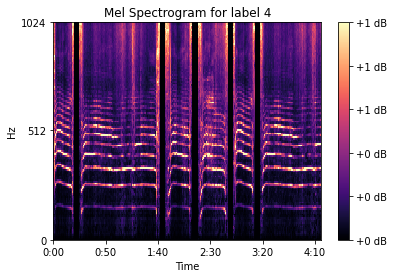

In [22]:
#example of a spectrogram selected randomly
import random
N=random.randint(0,1000)
librosa.display.specshow(dataset[N], sr=2048, hop_length=512, x_axis='time',y_axis='mel')
print(dataset[N].shape)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram for label '+ str(labels[N]))

#Model-1: Dense Neural Network

In [96]:
#X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.20, random_state=1150)

#print(X_train.shape)
#print(y_test[0])
#Y_train=tf.one_hot(y_train,depth=10)
#Y_train[0]

In [68]:
checkpoint_path = path_nn_save
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, monitor="val_loss", save_best_only=True,
                                                 save_weights_only=False, verbose=2,mode='min')

In [69]:
# NN

model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 1024)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

In [70]:
model_1.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [71]:
history=model_1.fit(dataset, y, epochs=16, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - ETA: 0s - loss: 22.5014 - accuracy: 0.1325
Epoch 1: val_loss improved from inf to 13.85060, saving model to /content/drive/MyDrive/MLSP-1/model_nn
25/25 [==============================] - 10s 402ms/step - loss: 22.5014 - accuracy: 0.1325 - val_loss: 13.8506 - val_accuracy: 0.1150
Epoch 2/16
25/25 [==============================] - ETA: 0s - loss: 5.3429 - accuracy: 0.2525
Epoch 2: val_loss improved from 13.85060 to 2.74530, saving model to /content/drive/MyDrive/MLSP-1/model_nn
25/25 [==============================] - 10s 405ms/step - loss: 5.3429 - accuracy: 0.2525 - val_loss: 2.7453 - val_accuracy: 0.3900
Epoch 3/16
25/25 [==============================] - ETA: 0s - loss: 2.0801 - accuracy: 0.4350
Epoch 3: val_loss improved from 2.74530 to 1.64908, saving model to /content/drive/MyDrive/MLSP-1/model_nn
25/25 [==============================] - 10s 397ms/step - loss: 2.0801 - accuracy: 0.4350 - val_loss: 1.6491 - val_accuracy: 0.4800
Epoch 4/16


In [76]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_11 (Dense)            (None, 1024)              134218752 
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
Total params: 134,818,122
Trainable params: 134,818,12

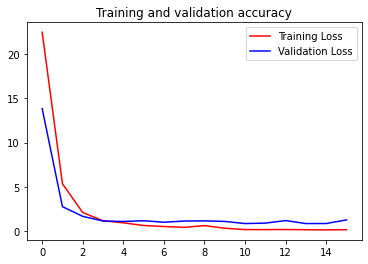

<Figure size 432x288 with 0 Axes>

In [77]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

#Model-2: Convolutional Neural Network

In [57]:
dataset_cnn=dataset
dataset_cnn=dataset_cnn.reshape((1000,128,-1,1))

#X_train, X_test, y_train, y_test = train_test_split(dataset_cnn, y, test_size=0.20, random_state=130)
#print(X_train.shape)
#print(y_test[0])

In [58]:
checkpoint_path = path_cnn_save
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, monitor="val_loss", save_best_only=True,
                                                 save_weights_only=False, verbose=2,mode='min')

In [59]:
#CNN

model = tf.keras.Sequential()

model.add(Conv2D(16, (5, 5), input_shape=(128,1024,1), activation='relu'))
#print(model.get_layer('conv2d_6'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))


model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(AveragePooling2D(pool_size=(2, 2)))
#'''
model.add(Dropout(0.2))

#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(1024, activation='relu')) 
model.add(Dense(64, activation='relu'))  

model.add(Dense(10, activation='softmax'))

In [60]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [61]:
history = model.fit(dataset_cnn, y, epochs=16, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/16
25/25 [==============================] - ETA: 0s - loss: 4.6590 - accuracy: 0.2225
Epoch 1: val_loss improved from inf to 2.09063, saving model to /content/drive/MyDrive/MLSP-1/model_cnn
25/25 [==============================] - 12s 454ms/step - loss: 4.6590 - accuracy: 0.2225 - val_loss: 2.0906 - val_accuracy: 0.3350
Epoch 2/16
25/25 [==============================] - ETA: 0s - loss: 1.7664 - accuracy: 0.4013
Epoch 2: val_loss improved from 2.09063 to 1.47295, saving model to /content/drive/MyDrive/MLSP-1/model_cnn
25/25 [==============================] - 10s 416ms/step - loss: 1.7664 - accuracy: 0.4013 - val_loss: 1.4730 - val_accuracy: 0.5350
Epoch 3/16
25/25 [==============================] - ETA: 0s - loss: 1.1187 - accuracy: 0.6350
Epoch 3: val_loss improved from 1.47295 to 0.96755, saving model to /content/drive/MyDrive/MLSP-1/model_cnn
25/25 [==============================] - 10s 416ms/step - loss: 1.1187 - accuracy: 0.6350 - val_loss: 0.9675 - val_accuracy: 0.7100
Ep

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 1020, 16)     416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 510, 16)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 62, 510, 16)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 508, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 254, 32)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 254, 32)      

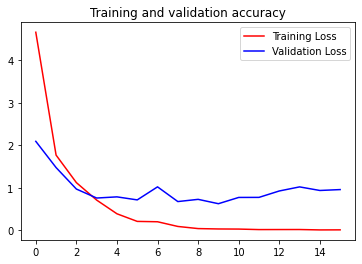

<Figure size 432x288 with 0 Axes>

In [67]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

#Process Test Data

In [ ]:
!unzip /content/drive/MyDrive/MLSP-1/test_1.zip -d '/content/test_1'

In [24]:
path_test='/content/test_1'

In [25]:
test_data = {}
for fname in os.listdir(path_test):
    test_data[fname]=(np.load(os.path.join(path_test, fname)))


In [26]:
#resizing the 3rd dimension to 1024 for all samples
resized_testdata={}
for fname in os.listdir(path_test):
    temp=test_data[fname][0]
    temp=np.array(temp)
    tup=temp.shape
    #print(tup[1])
    if(tup[1]>1024):                                        #clip the 3rd dimension if greater than 1024
      resized_testdata[fname]=temp[:,0:1024]
    else:
      times=int(1024/tup[1])+1
      temp_1=temp                                           #repeat the 3rd dimension if less than 1024, upto 1024
      for i in range(times):
        temp_1=np.concatenate([temp_1,temp],axis=1)
      resized_testdata[fname]=temp_1[:,0:1024]
    #print(resized_data[fname].shape)

In [27]:
#preprocessing using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

normalized_test_data={}
for fname in os.listdir(path_test):
  scaler.fit(resized_testdata[fname])
  normalized_test_data[fname] = scaler.transform(resized_testdata[fname])
  #print(normalized_train_data[fname].shape)
  #print(np.amax(normalized_train_data[fname]))

In [28]:
#create the dataset

int_index=0
dataset_test=[]
#labels=[]
for i in os.listdir(path_test):
  #print(i)
  dataset_test.append(normalized_test_data[i])
  #labels.append(data_total[i])
  int_index=int_index+1
dataset_test=np.array(dataset_test)
dataset_test.shape
#print(dataset[0],labels[0])
#print(normalized_train_data['57112910.npy'],data_total['57112910.npy'])

(201, 128, 1024)

#Predictions of Test Data

In [72]:
model_saved = keras.models.load_model('/content/drive/MyDrive/MLSP-1/model_nn')

In [73]:
predictions=model_saved.predict(dataset_test)

In [74]:
#convert from one-hot to label
predictions_final=[]
for i in range(predictions.shape[0]):
  predictions_final.append(np.argmax(predictions[i]))
#print(len(predictions_final))

In [75]:
#make csv file
np.savetxt("predic_nn_2.csv",predictions_final,delimiter=",")

In [ ]:
#convert from one-hot to label
y_test_final=[]
for i in range(y_test.shape[0]):
  y_test_final.append(np.argmax(y_test[i]))

In [ ]:
#to find TP, TN, FP,FN of different classes
def confusion(predictions_final,Y_test):
  confusion_arr=np.zeros((10,4),dtype=int) #TP FP TN FN
  for c in range(10):
    for i in range(len(predictions_final)):
      label_true=Y_test[i]
      pred=predictions_final[i]
      if(label_true==c and pred==c):
        confusion_arr[c][0]+=1 #TP
      elif(pred==c):
        confusion_arr[c][1]+=1 #FP
      elif(label_true==c):
        confusion_arr[c][3]+=1 #FN
      else:
        confusion_arr[c][2]+=1 #TN
  return confusion_arr

###Calculate the Precision, Recall and F1 Score

In [ ]:
def p_r_f1(confusion_arr):
  precision_arr=np.zeros(10)
  recall_arr=np.zeros(10)
  f1_arr=np.zeros(10);
  for i in range(10):
    precision_arr[i]=confusion_arr[i][0]/(confusion_arr[i][0] + confusion_arr[i][1])
    recall_arr[i]=confusion_arr[i][0]/(confusion_arr[i][0] + confusion_arr[i][3])
    f1_arr[i]=(2*precision_arr[i]*recall_arr[i])/(precision_arr[i]+recall_arr[i])
  return precision_arr, recall_arr, f1_arr

###Confusion Matrix

In [ ]:
##Create confusion matrix
def conf(predictions_final,Y_test):
  confusion_matrix=np.zeros((10,10),dtype=int)
  for i in range(len(predictions_final)):
    pre=predictions_final[i]
    act=Y_test[i]
    confusion_matrix[act][pre]+=1
  np.savetxt("conf_matrix.csv",confusion_matrix,delimiter=",")


In [ ]:
confusion_arr=confusion(predictions_final,y_test_final)

In [ ]:
precision_arr, recall_arr, f1_arr=p_r_f1(confusion_arr)

In [ ]:
print(precision_arr)

In [ ]:
print(recall_arr)

In [ ]:
f1_arr